In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1563, 24)
(1563, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24316425621509552,
       0.12834718823432922, -0.3836668133735657, 0.23878607153892517,
       -0.131938174366951, -0.36480507254600525, -0.2585662603378296,
       0.12253835797309875, -0.3686639368534088, -0.25985878705978394,
       -0.12464121729135513, -0.3830992579460144, -0.0035856561735272408,
       -0.027014970779418945, -0.07533848285675049,
       -0.0029825393576174974, True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(780,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24316425621509552,
       0.12834718823432922, -0.3836668133735657, 0.23878607153892517,
       -0.131938174366951, -0.36480507254600525, -0.2585662603378296,
       0.12253835797309875, -0.3686639368534088, -0.25985878705978394,
       -0.12464121729135513, -0.3830992579460144, -0.0035856561735272408,
       -0.027014970779418945, -0.07533848285675049,
       -0.0029825393576174974, True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.0002006561349540137, -0.005639766167924484,
       0.0009616162325033761], dtype=object)

## Predict CoM -> x

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9685816441110301
RMSE:  0.011593508123272197
The lowest error is:  2.8615770197637502e-05
The highest error is:  0.05718969766764556
The avg. error is:  0.007275590163938459


In [13]:
model_fl_com_x.coef_

array([[ 2.66751743e-02,  1.38777878e-16,  1.42247325e-16,
         9.26221151e-02, -5.03069808e-17,  0.00000000e+00,
         1.56269092e-01,  1.43314323e-01, -1.81078356e-01,
         9.09167367e-02,  5.77755570e-02,  8.09996484e-01,
        -3.18292769e-01, -4.74754053e-01, -2.64627878e-01,
        -4.62764027e-01]])

In [14]:
model_fl_com_x.intercept_

array([-0.02635813])

In [17]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.00777596]])

Text(0, 0.5, 'Predictions')

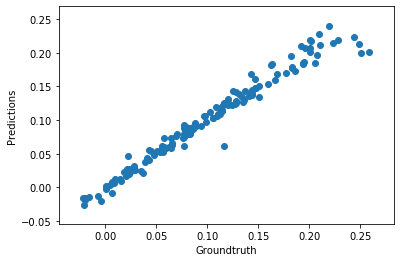

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [19]:
#%store model_fl_com_x

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [16]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.34658997882491427
RMSE:  0.003191042600763817
The lowest error is:  2.139265042590266e-06
The highest error is:  0.011190943047531252
The avg. error is:  0.00246836244070809


In [17]:
model_fl_com_y.coef_

array([[-7.63795257e-03,  9.88792381e-17,  4.48859699e-17,
        -5.20413775e-03,  8.32667268e-17,  8.32667268e-17,
         2.65923829e-02,  3.50477475e-02, -6.55375587e-02,
        -6.16992332e-01, -1.45162011e-02,  1.87841254e-01,
        -5.79500971e-02,  2.42237013e-01,  7.56547034e-02,
        -1.41740382e-01]])

In [18]:
model_fl_com_y.intercept_

array([0.07838211])

Text(0, 0.5, 'Predictions')

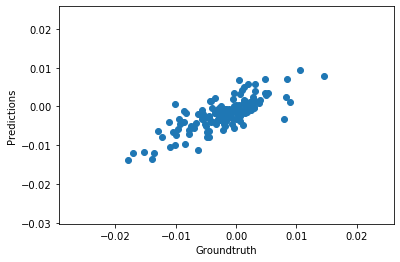

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [26]:
#%store model_fl_com_y

In [27]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [28]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.2102738690680277
RMSE:  0.0036899797305030317
The lowest error is:  5.4467209349762236e-05
The highest error is:  0.03653144775440735
The avg. error is:  0.001976103422925759


In [21]:
model_fl_com_theta.coef_

array([[-1.90015251e-03,  3.90312782e-17, -2.77555756e-17,
        -5.77162931e-03,  1.38777878e-17,  3.46944695e-18,
        -1.31021122e-03,  1.61281065e-03, -9.45502857e-03,
        -1.02454999e-01,  4.40775613e-02,  7.49503730e-02,
        -1.10810000e-02, -2.74835149e-02,  4.55750462e-02,
         1.09063793e-01]])

In [22]:
model_fl_com_theta.intercept_

array([0.04220108])

Text(0, 0.5, 'Predictions')

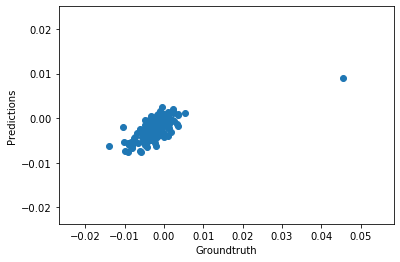

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")